In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random


In [2]:
# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)


In [3]:
batch_size = 100
learning_rate = 0.002
num_epoch = 10


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])




In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,1,1),                            # batch x 16 x 120 x 80
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,stride=1,padding=1),                           # batch x 32 x 120 x 80
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,stride=1,padding=1),                           # batch x 32 x 120 x 80
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 60 x 40
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,stride=1,padding=1),                          # batch x 128 x 60 x 40
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,stride=1,padding=1),                         # batch x 256 x 30 x 20
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(256,512,3,stride=1,padding=1),                          # batch x 512 x 15 x 10
                        nn.ReLU(),
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(batch_size, -1)
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer0 = nn.Sequential(
            #nn.COnvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
                        nn.ConvTranspose2d(512,256,3,2,1,1),                    # batch x 512 x 30 x 20
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.ConvTranspose2d(256,128,3,1,1),                       # batch x 256 x 30 x 20
                        nn.ReLU(),
                        nn.BatchNorm2d(128)
        )
        self.layer1 = nn.Sequential(
            #nn.COnvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
                        nn.ConvTranspose2d(128,64,3,2,1,1),                       # batch x 64 x 60 x 40
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 60 x 40
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 120 x 80
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,512,15,10)
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        return out


In [6]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

Output (text)

Print out the followings at each epoch

The average of the training loss over mini-batch iterations at each epoch
[epoch #####] loss: (training) ########




Output (graph)

Plot the average of the training loss over mini-batch iterations at each epoch
Plot the standard deviation of the training loss over mini-batch iterations at each epoch

In [14]:
# for training
traindata = np.load('data/train.npy')
traindataset = numpyDataset(traindata, transform)
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=0)


--------model not restored--------

[epoch 0000] loss: (training) 0.07587385922670364
[epoch 0001] loss: (training) 0.014460253529250622
[epoch 0002] loss: (training) 0.009644179604947567
[epoch 0003] loss: (training) 0.007680027280002832
[epoch 0004] loss: (training) 0.005552732851356268
[epoch 0005] loss: (training) 0.004793438594788313
[epoch 0006] loss: (training) 0.004081554710865021
[epoch 0007] loss: (training) 0.003627218073233962
[epoch 0008] loss: (training) 0.002892433200031519
[epoch 0009] loss: (training) 0.002550760516896844
[epoch 0010] loss: (training) 0.0022351781371980906
[epoch 0011] loss: (training) 0.0023039469961076975
[epoch 0012] loss: (training) 0.0021613091230392456
[epoch 0013] loss: (training) 0.00194283458404243
[epoch 0014] loss: (training) 0.0021201842464506626
[epoch 0015] loss: (training) 0.0018090240191668272
[epoch 0016] loss: (training) 0.0031973973382264376
[epoch 0017] loss: (training) 0.0021858050022274256
[epoch 0018] loss: (training) 0.00217103

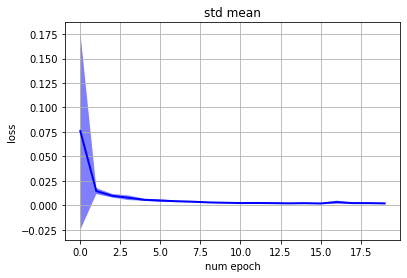

In [20]:
# 모델을 불러오는 방법입니다.
# 크게 두가지 방법이 있는데 여기 사용된 방법은 좀 단순한 방법입니다.
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
   
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

noises = [0.01, 0.02, 0.03, 0.04]
loss_train_mean = []
loss_train_std = []
for i in range(num_epoch):
    losses = []
    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        noise_factor = noises[random.randint(0,3)]
        noise = init.normal_(torch.FloatTensor(batch_size,1, 120, 80), 0, noise_factor).to(device)
        x = data.to(device)
        
        noised_x = x + noise
        
        output = encoder(noised_x)
        output = decoder(output)
        
        loss = loss_func(x,output)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
    
    loss_m = np.mean(losses)
    loss_train_mean.append(loss_m)
    loss_train_std.append(np.std(losses))
    print(f"[epoch {i:04}] loss: (training) {loss_m}")

torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')



t = np.arange(num_epoch)
fig, ax = plt.subplots(1)
mu1 = np.squeeze(loss_train_mean)
sigma1 = np.squeeze(loss_train_std)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title("std mean")
ax.set_xlabel('num epoch')
ax.set_ylabel('loss')
ax.grid()

[epoch 0000] loss: (training) 0.12122411280870438
[epoch 0001] loss: (training) 0.06721348315477371
[epoch 0002] loss: (training) 0.03718492016196251
[epoch 0003] loss: (training) 0.019856952130794525
[epoch 0004] loss: (training) 0.014635286293923855
[epoch 0005] loss: (training) 0.012201872654259205
[epoch 0006] loss: (training) 0.008020302280783653
[epoch 0007] loss: (training) 0.006215665955096483
[epoch 0008] loss: (training) 0.007080003619194031
[epoch 0009] loss: (training) 0.00556368799880147


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

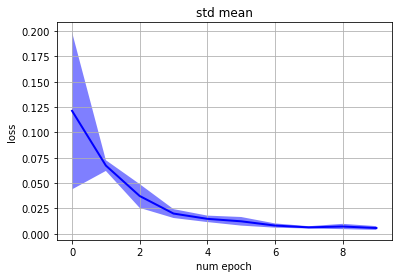

In [9]:
noises = [0.01, 0.02, 0.03, 0.04]
loss_train_mean = []
loss_train_std = []
for i in range(num_epoch):
    losses = []
    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        noise_factor = noises[random.randint(0,3)]
        noise = init.normal_(torch.FloatTensor(batch_size,1, 120, 80), 0, noise_factor).to(device)
        x = data.to(device)
        
        noised_x = x + noise
        
        output = encoder(noised_x)
        output = decoder(output)
        
        loss = loss_func(x,output)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
    
    loss_m = np.mean(losses)
    loss_train_mean.append(loss_m)
    loss_train_std.append(np.std(losses))
    print(f"[epoch {i:04}] loss: (training) {loss_m}")

torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')



t = np.arange(num_epoch)
fig, ax = plt.subplots(1)
mu1 = np.squeeze(loss_train_mean)
sigma1 = np.squeeze(loss_train_std)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title("std mean")
ax.set_xlabel('num epoch')
ax.set_ylabel('loss')
ax.grid()

torch.Size([100, 120, 80])


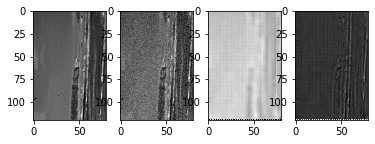

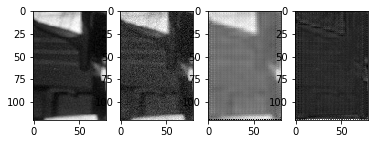

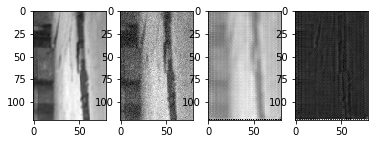

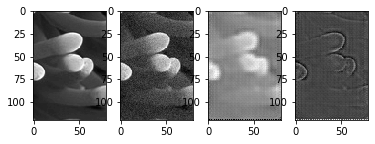

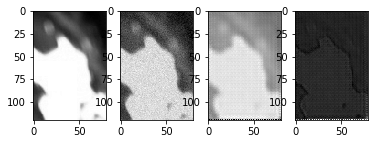

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,4,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(torch.squeeze(noised_x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,4,3)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.subplot(1,4,4)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy() - out_img[i].numpy(),cmap='gray')
    plt.show()

[epoch 0000] loss: (training) 0.10173147171735764
[epoch 0001] loss: (training) 0.01942264847457409
[epoch 0002] loss: (training) 0.011892938055098057
[epoch 0003] loss: (training) 0.010855820961296558
[epoch 0004] loss: (training) 0.007528251502662897
[epoch 0005] loss: (training) 0.00689096050336957
[epoch 0006] loss: (training) 0.0077262450940907
[epoch 0007] loss: (training) 0.005092071369290352
[epoch 0008] loss: (training) 0.004739304538816214
[epoch 0009] loss: (training) 0.0054841297678649426
[epoch 0010] loss: (training) 0.004551440477371216
[epoch 0011] loss: (training) 0.0037867375649511814
[epoch 0012] loss: (training) 0.002889052964746952
[epoch 0013] loss: (training) 0.002428668551146984
[epoch 0014] loss: (training) 0.002270533237606287
[epoch 0015] loss: (training) 0.0022022733464837074
[epoch 0016] loss: (training) 0.002127276500687003
[epoch 0017] loss: (training) 0.0019421224715188146
[epoch 0018] loss: (training) 0.0018906061304733157
[epoch 0019] loss: (training) 0

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

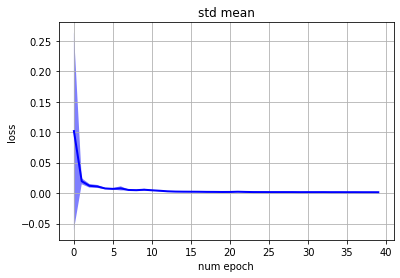

In [8]:
learning_rate = 0.005
num_epoch = 40
noises = [0.01, 0.02, 0.03, 0.04]
loss_train_mean = []
loss_train_std = []
for i in range(num_epoch):
    losses = []
    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        noise_factor = noises[random.randint(0,3)]
        noise = init.normal_(torch.FloatTensor(batch_size,1, 120, 80), 0, noise_factor).to(device)
        x = data.to(device)
        
        noised_x = x + noise
        
        output = encoder(noised_x)
        output = decoder(output)
        
        loss = loss_func(x,output)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
    
    loss_m = np.mean(losses)
    loss_train_mean.append(loss_m)
    loss_train_std.append(np.std(losses))
    print(f"[epoch {i:04}] loss: (training) {loss_m}")

torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')



t = np.arange(num_epoch)
fig, ax = plt.subplots(1)
mu1 = np.squeeze(loss_train_mean)
sigma1 = np.squeeze(loss_train_std)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title("std mean")
ax.set_xlabel('num epoch')
ax.set_ylabel('loss')
ax.grid()

In [14]:
batch_size = 100
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl', map_location={'cuda:0':'cpu'})
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


# for testing
testdata        = np.load('data/test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cpu"
result_for_submit = None    # this is for submit file


for batch_idx, data in enumerate(testloader):
    x = data.to(device)
    output = encoder(x)
    result_of_test = decoder(output)
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim =0)
        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

    
submit_file = result_for_submit.detach().numpy()
np.save("youngsooNa.npy", submit_file)
print("done")


--------model restored--------

3


In [6]:
# for training
traindata = np.load("youngsooNa.npy")
traindataset = numpyDataset(traindata, transform)
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=False, num_workers=0)

testdata = np.load('data/test.npy')
testdataset = numpyDataset(testdata, transform)
testloader = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)
        

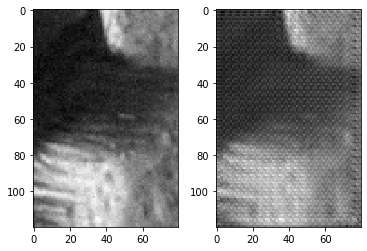

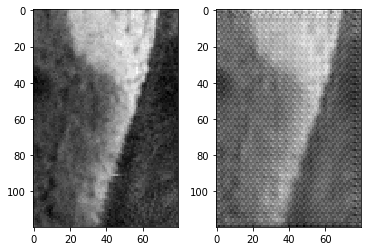

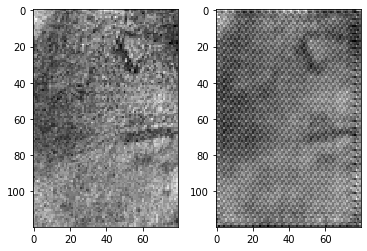

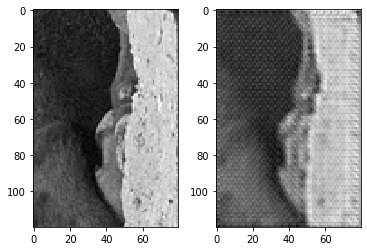

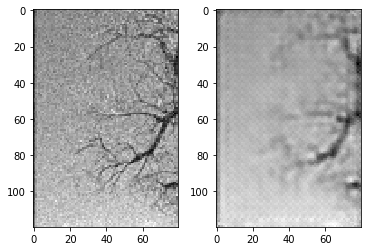

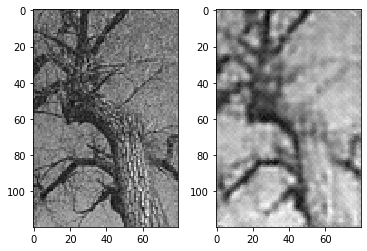

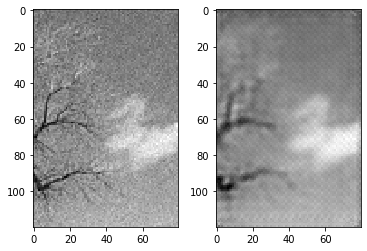

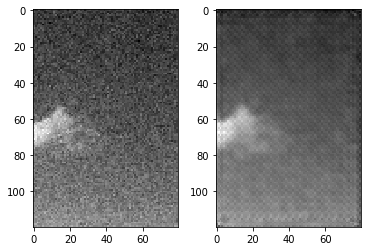

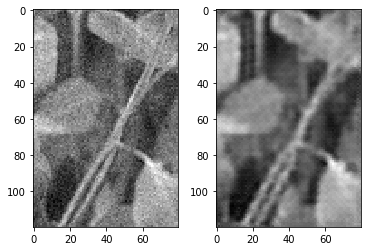

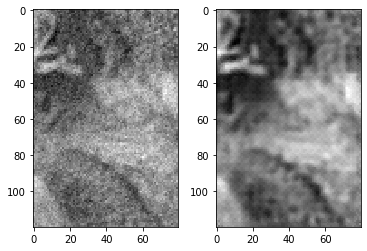

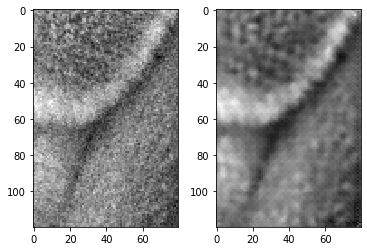

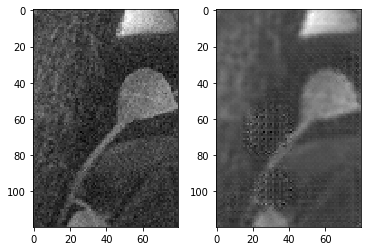

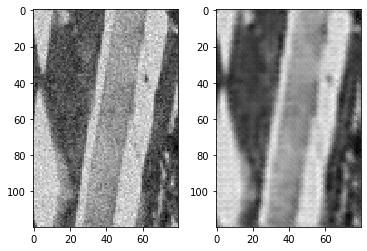

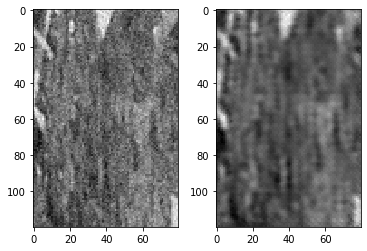

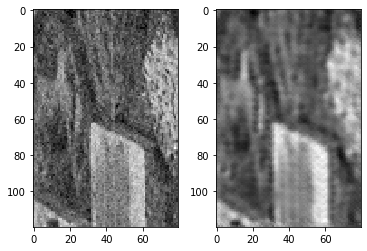

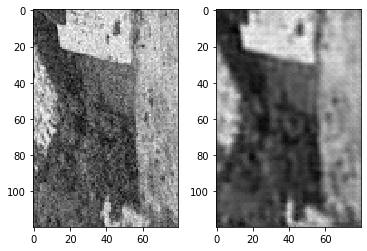

In [7]:
count = 0
images_train = []
images_test = []

for epoch in range(1):
    for batch_idx, data in enumerate(trainloader):
        for i in range(4):
            image   = data[i]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_train.append(image)
for epoch in range(1):
    for batch_idx, data in enumerate(testloader):
        for k in range(4):
            image   = data[k]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_test.append(image)

for i in range(len(images_train)):
    plt.subplot(1,2,1)
    plt.imshow(images_test[i],cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images_train[i],cmap='gray')
    plt.show()
    

[epoch 0000] loss: (training) 0.13854967057704926
[epoch 0001] loss: (training) 0.06445834040641785
[epoch 0002] loss: (training) 0.024015946313738823
[epoch 0003] loss: (training) 0.01213909313082695
[epoch 0004] loss: (training) 0.009084836579859257
[epoch 0005] loss: (training) 0.015116173774003983
[epoch 0006] loss: (training) 0.011364194564521313
[epoch 0007] loss: (training) 0.007819481194019318
[epoch 0008] loss: (training) 0.0057889739982783794
[epoch 0009] loss: (training) 0.005178643390536308
[epoch 0010] loss: (training) 0.004587316885590553
[epoch 0011] loss: (training) 0.004079857841134071
[epoch 0012] loss: (training) 0.0037774331867694855
[epoch 0013] loss: (training) 0.0036521584261208773
[epoch 0014] loss: (training) 0.0037656163331121206
[epoch 0015] loss: (training) 0.0073194862343370914
[epoch 0016] loss: (training) 0.004766164347529411
[epoch 0017] loss: (training) 0.003891986794769764
[epoch 0018] loss: (training) 0.0036353766918182373
[epoch 0019] loss: (training

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

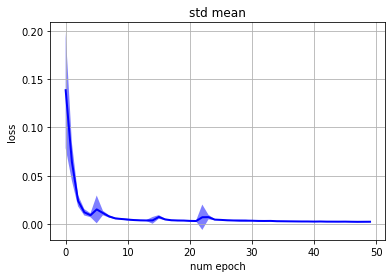

In [8]:
learning_rate = 0.005
num_epoch = 50
noises = [0.01, 0.02, 0.03, 0.04]
loss_train_mean = []
loss_train_std = []
for i in range(num_epoch):
    losses = []
    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        noise_factor = noises[random.randint(0,3)]
        noise = init.normal_(torch.FloatTensor(batch_size,1, 120, 80), 0, noise_factor).to(device)
        x = data.to(device)
        
        noised_x = x + noise
        
        output = encoder(noised_x)
        output = decoder(output)
        
        loss = loss_func(x,output)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
    
    loss_m = np.mean(losses)
    loss_train_mean.append(loss_m)
    loss_train_std.append(np.std(losses))
    print(f"[epoch {i:04}] loss: (training) {loss_m}")

torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')



t = np.arange(num_epoch)
fig, ax = plt.subplots(1)
mu1 = np.squeeze(loss_train_mean)
sigma1 = np.squeeze(loss_train_std)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title("std mean")
ax.set_xlabel('num epoch')
ax.set_ylabel('loss')
ax.grid()

In [7]:
batch_size = 100
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl', map_location={'cuda:0':'cpu'})
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


# for testing
testdata        = np.load('data/test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cpu"
result_for_submit = None    # this is for submit file


for batch_idx, data in enumerate(testloader):
    x = data.to(device)
    output = encoder(x)
    result_of_test = decoder(output)
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim =0)
        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

    
submit_file = result_for_submit.detach().numpy()
np.save("youngsooNa.npy", submit_file)
print("done")


--------model restored--------

done


In [7]:
# for training
traindata = np.load("youngsooNa.npy")
traindataset = numpyDataset(traindata, transform)
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=False, num_workers=0)

testdata = np.load('data/test.npy')
testdataset = numpyDataset(testdata, transform)
testloader = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)

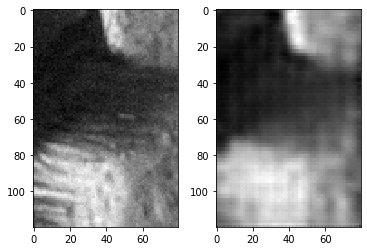

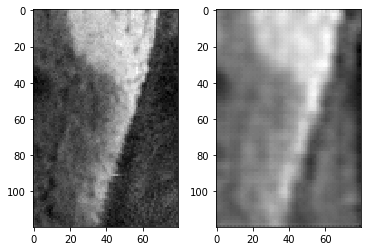

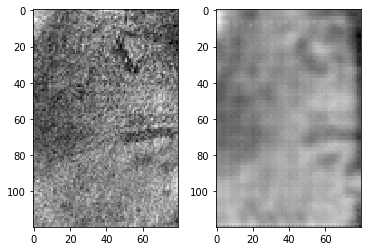

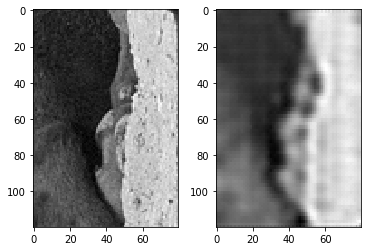

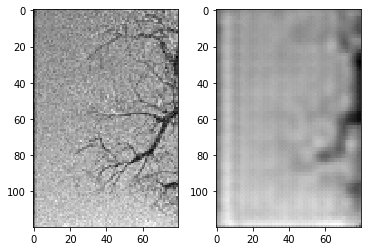

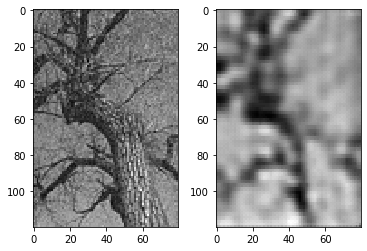

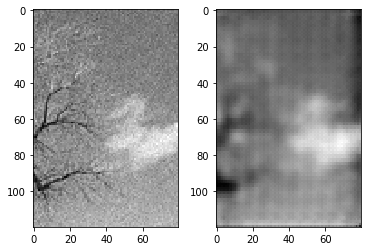

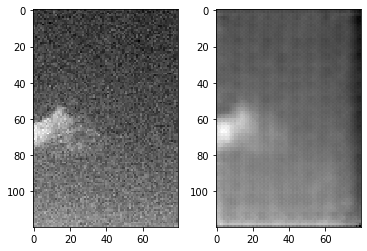

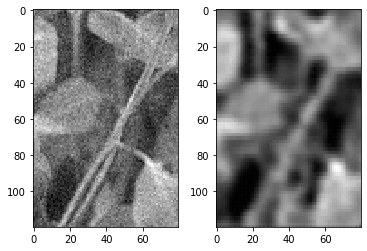

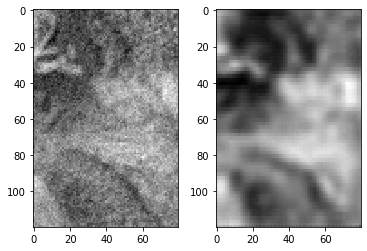

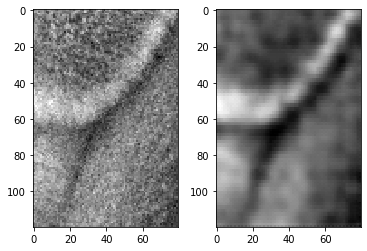

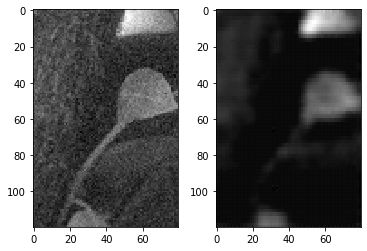

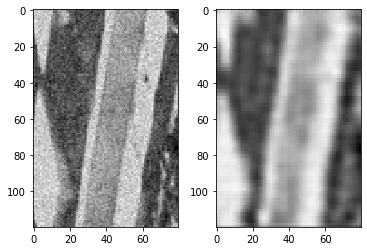

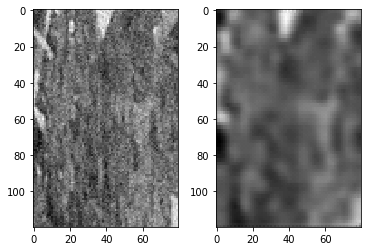

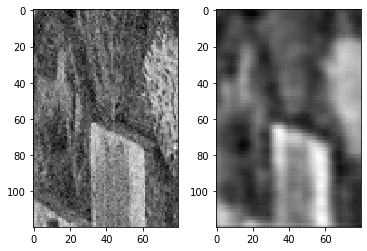

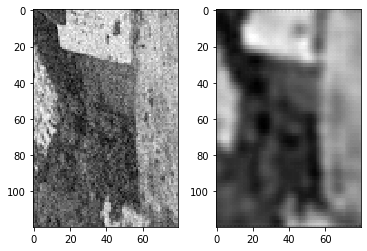

In [8]:
count = 0
images_train = []
images_test = []

for epoch in range(1):
    for batch_idx, data in enumerate(trainloader):
        for i in range(4):
            image   = data[i]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_train.append(image)
for epoch in range(1):
    for batch_idx, data in enumerate(testloader):
        for k in range(4):
            image   = data[k]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_test.append(image)

for i in range(len(images_train)):
    plt.subplot(1,2,1)
    plt.imshow(images_test[i],cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images_train[i],cmap='gray')
    plt.show()
    

[epoch 0000] loss: (training) 0.08979548513889313
[epoch 0001] loss: (training) 0.02051994949579239
[epoch 0002] loss: (training) 0.011784336529672146
[epoch 0003] loss: (training) 0.009300763718783855
[epoch 0004] loss: (training) 0.007806999608874321
[epoch 0005] loss: (training) 0.005886140279471874
[epoch 0006] loss: (training) 0.004995549097657204
[epoch 0007] loss: (training) 0.00413916539400816
[epoch 0008] loss: (training) 0.0046034217812120914
[epoch 0009] loss: (training) 0.004197721369564533
[epoch 0010] loss: (training) 0.0034219773951917887
[epoch 0011] loss: (training) 0.0030697816982865334
[epoch 0012] loss: (training) 0.0028481970075517893
[epoch 0013] loss: (training) 0.0028380181174725294
[epoch 0014] loss: (training) 0.0026241561863571405
[epoch 0015] loss: (training) 0.00257122702896595
[epoch 0016] loss: (training) 0.0024911670479923487
[epoch 0017] loss: (training) 0.0024620217736810446
[epoch 0018] loss: (training) 0.0022724869195371866
[epoch 0019] loss: (traini

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

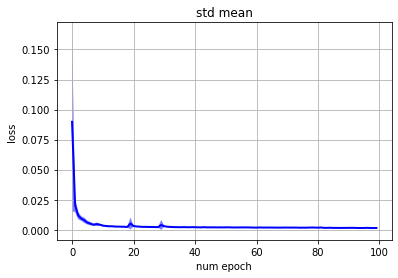

In [15]:
learning_rate = 0.005
num_epoch = 100
noises = [0.01, 0.02, 0.03, 0.04]
loss_train_mean = []
loss_train_std = []
for i in range(num_epoch):
    losses = []
    for batch_idx, data in enumerate(trainloader):
        optimizer.zero_grad()
        noise_factor = noises[random.randint(0,3)]
        noise = init.normal_(torch.FloatTensor(batch_size,1, 120, 80), 0, noise_factor).to(device)
        x = data.to(device)
        
        noised_x = x + noise
        
        output = encoder(noised_x)
        output = decoder(output)
        
        loss = loss_func(x,output)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
    
    loss_m = np.mean(losses)
    loss_train_mean.append(loss_m)
    loss_train_std.append(np.std(losses))
    print(f"[epoch {i:04}] loss: (training) {loss_m}")

torch.save([encoder,decoder],'./model/conv_autoencoder.pkl')



t = np.arange(num_epoch)
fig, ax = plt.subplots(1)
mu1 = np.squeeze(loss_train_mean)
sigma1 = np.squeeze(loss_train_std)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.set_title("std mean")
ax.set_xlabel('num epoch')
ax.set_ylabel('loss')
ax.grid()

torch.Size([100, 120, 80])


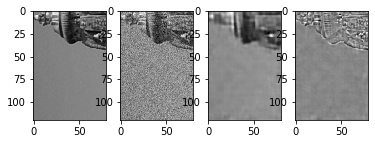

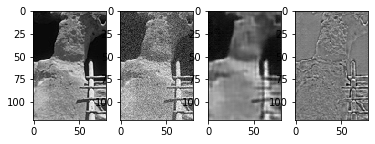

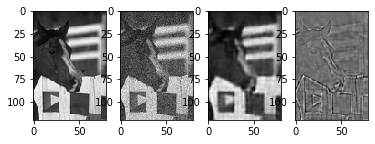

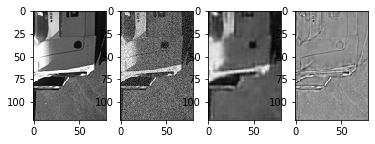

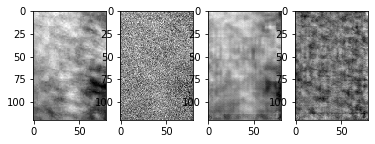

In [16]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,4,1)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(torch.squeeze(noised_x[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,4,3)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.subplot(1,4,4)
    plt.imshow(torch.squeeze(x[i]).cpu().numpy() - out_img[i].numpy(),cmap='gray')
    plt.show()

In [7]:
batch_size = 100
try:
    encoder, decoder = torch.load('./model/conv_autoencoder.pkl', map_location={'cuda:0':'cpu'})
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


# for testing
testdata        = np.load('data/test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cpu"
result_for_submit = None    # this is for submit file


for batch_idx, data in enumerate(testloader):
    x = data.to(device)
    output = encoder(x)
    result_of_test = decoder(output)
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim =0)
        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

    
submit_file = result_for_submit.detach().numpy()
np.save("youngsooNa.npy", submit_file)
print("done")


--------model restored--------

done


In [7]:
# for training
traindata = np.load("youngsooNa.npy")
traindataset = numpyDataset(traindata, transform)
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=False, num_workers=0)

testdata = np.load('data/test.npy')
testdataset = numpyDataset(testdata, transform)
testloader = DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=0)

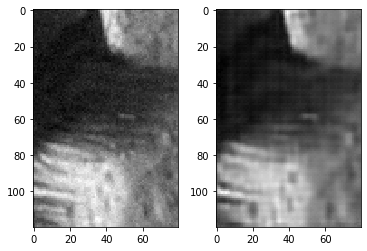

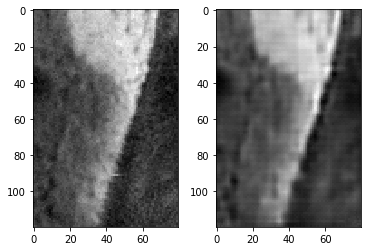

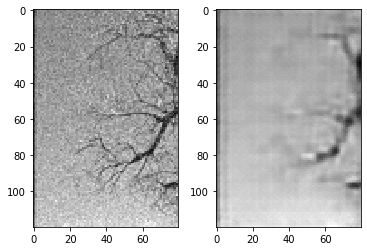

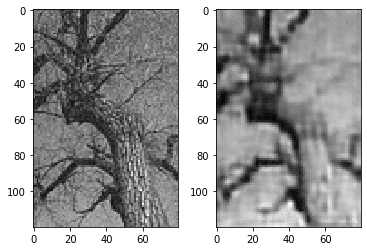

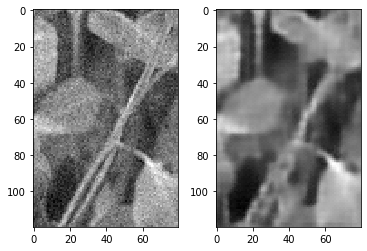

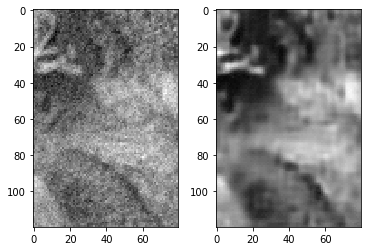

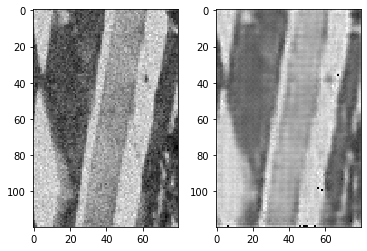

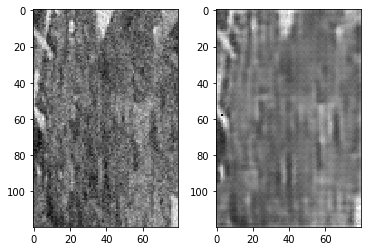

In [8]:
count = 0
images_train = []
images_test = []

for epoch in range(1):
    for batch_idx, data in enumerate(trainloader):
        for i in range(2):
            image   = data[i]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_train.append(image)
for epoch in range(1):
    for batch_idx, data in enumerate(testloader):
        for k in range(2):
            image   = data[k]
            to_img  = transforms.ToPILImage()
            image   = to_img(image)
            images_test.append(image)

for i in range(len(images_train)):
    plt.subplot(1,2,1)
    plt.imshow(images_test[i],cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(images_train[i],cmap='gray')
    plt.show()